In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS에 따라 기본 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    # Mac 기본 한글 폰트
else:
    # 리눅스: 나눔고딕 또는 설치된 한글 폰트 확인 필요
    plt.rcParams['font.family'] = 'NanumGothic'     # 또는 'DejaVu Sans' 등

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.contingency_tables import cochrans_q

from scipy.stats import ttest_ind , chi2_contingency

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv",index_col=0)
df = df.drop(columns = 'id', axis = 1)
df.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,male,27,1.80,87,no,no,always,3,sometimes,no,between 1 and 2 l,no,2 to 4,0 to 2,frequently,walking,overweight_level_i,26.851852
1,male,26,1.85,105,yes,yes,always,3,frequently,no,more than 2 l,no,2 to 4,>5,sometimes,public_transportation,obesity_type_i,30.679328
2,male,41,1.80,99,no,yes,sometimes,3,sometimes,no,between 1 and 2 l,no,2 to 4,3 to 5,frequently,automobile,obesity_type_i,30.555556


In [3]:
## 1) EDA, 결측, 이상치 

In [4]:
# 1) 결측
display(df.isna().sum().to_frame().T)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


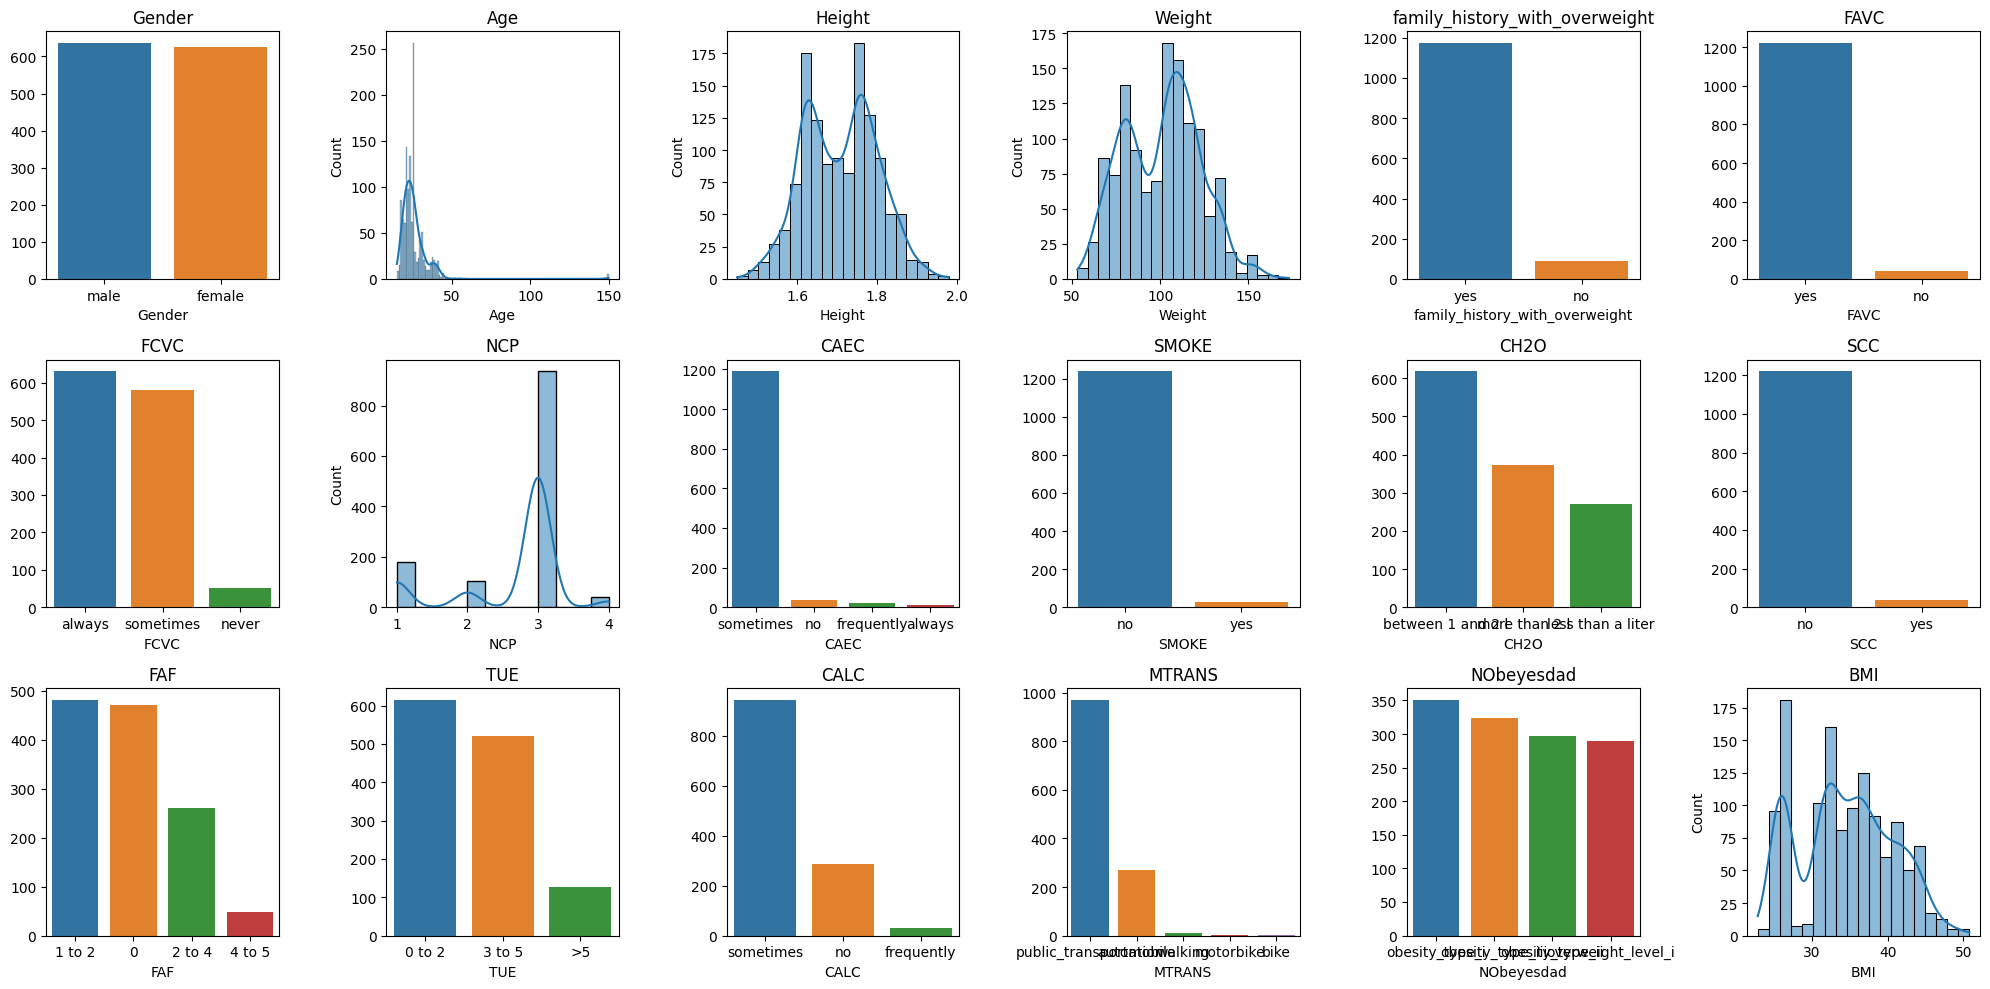

In [5]:
# 2) EDA 
fig, axes = plt.subplots(3,6, figsize= (20, 10) )
for axes, col in zip(axes.flatten() , df.columns)  : 
    if df[col].dtypes == 'object' and df[col].nunique() == 2 : 
        target = df[col].value_counts() 
        sns.barplot(x = target.index, y = target.values, hue = target.index, ax = axes)
        axes.set_title(f'{col}') 

    elif df[col].dtypes == 'object' and 3 <= df[col].nunique() < 6 : 
        target = df[col].value_counts()
        sns.barplot(x = target.index, y = target.values, hue = target.index, ax = axes)
        axes.set_title(f'{col}')  

    else : 
        sns.histplot(df[col], kde = True, ax = axes)
        axes.set_title(f'{col}')

plt.tight_layout()
plt.show()

<Axes: >

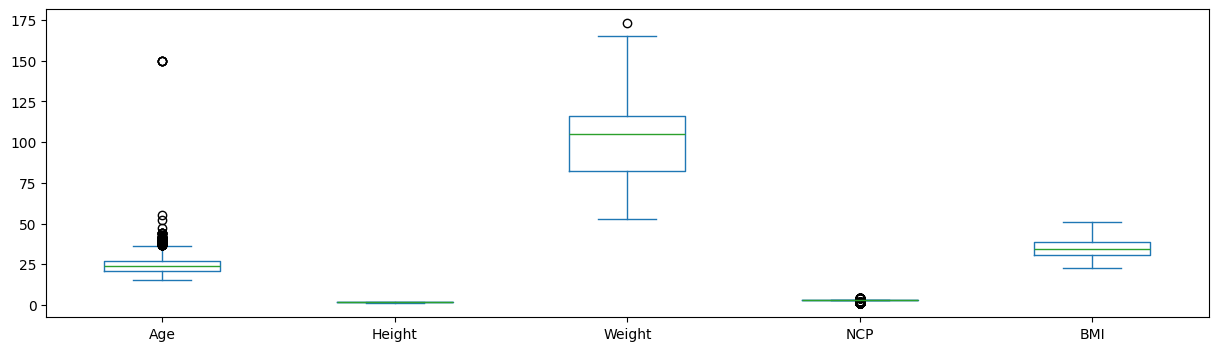

In [6]:
## 이상치 - 숫자형 변수만 
num_cols = df.select_dtypes(exclude = 'object').columns

fig, axes = plt.subplots(1,1, figsize = (15,4))
df[num_cols].plot(kind = 'box', ax = axes)

In [7]:
## 데이터 전처리 기법 

# 1) 결측 처리 
df1 = df.dropna().reset_index(drop = True)

# 2) 이상치 처리 나이 100 이하 
df2 = df1[df1['Age'] <= 100].reset_index(drop = True)

# 3) 전처리 
clean_df = pd.DataFrame()
for col in df2.columns : 
    if df2[col].nunique() == 2 : 
        dummies = pd.get_dummies(df2[col] , prefix = col, dtype = int) 
        for d_col in dummies.columns : 
            clean_df[d_col] = dummies[d_col] 

    elif 3 <= df2[col].nunique() < 6 :
        la = LabelEncoder()
        clean_df[col] = la.fit_transform(df2[col]) 

    else : 
        clean_df[col] = StandardScaler().fit_transform(df2[[col]]).flatten() 

clean_df.head()
        

,Gender_female,Gender_male,Age,Height,Weight,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,FCVC,...,SMOKE_yes,CH2O,SCC_no,SCC_yes,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,1,0.287374,1.000803,-0.653360,1,0,1,0,0,...,0,0,1,0,2,0,0,4,3,-1.243055
1,0,1,0.122295,1.549549,0.184051,0,1,0,1,0,...,0,2,1,0,2,2,2,3,0,-0.616213
2,0,1,2.598474,1.000803,-0.095086,1,0,0,1,2,...,0,0,1,0,2,1,0,0,0,-0.636484
3,1,0,0.617531,-1.962423,-1.072065,1,0,0,1,2,...,0,0,1,0,0,0,1,0,0,-0.183655
4,1,0,-0.372941,-0.645433,-1.444248,0,1,1,0,2,...,0,0,1,0,0,0,2,3,3,-1.429789


In [8]:
# 파생변수 
clean_df['Activity'] = clean_df['FAF'] + clean_df['TUE'] 

In [9]:
# 2-1 앙상블을 제외한 분류 모델 3가지 구축 및 결과 비교 및 설명
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score, recall_score 

In [10]:
X = clean_df.drop(columns = 'NObeyesdad' , axis = 1)
y = clean_df['NObeyesdad']

def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    return name, acc, f1 

res = []
for name, model in [['SVC',SVC()] , ['KNN', KNeighborsClassifier()] , ['LG', LogisticRegression(max_iter=1000)]] : 
    name, acc, f1 = classifying_model(name, model)
    res.append({
        'Model' : name, 
        'Accuracy_Score' : acc, 
        'F1_Score' : f1
    })

pd.DataFrame(res)

,Model,Accuracy_Score,F1_Score
0,SVC,0.986737,0.986747
1,KNN,0.944297,0.944161
2,LG,0.992042,0.992048


{'Model': 'LogisticRegression',
 'Accuracy_Score': 0.9920424403183024,
 'F1_score': 0.9920475377672314,
 'Precision': 0.9921288406371708,
 'Recall': 0.9920424403183024}

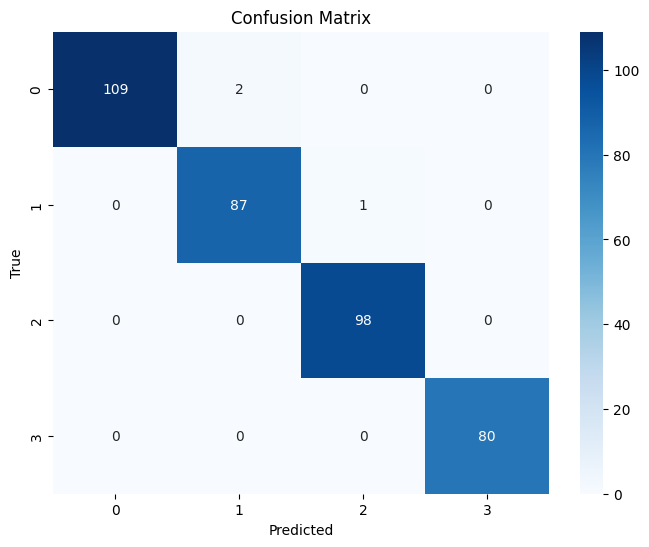

In [11]:
#  2-2 사용한 모델 중 하나를 골라 그리드 서치를 통해서 파라미터 튜닝 및 분류 모델 성능 평가 (precision ,recall)
def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)

    params = {
        'C': [0.01, 0.1, 1, 10],        # 규제강도
        'solver': ['liblinear', 'lbfgs'] # 최적화 알고리즘
    }

    grid = GridSearchCV(model, params, cv = 3, scoring = 'accuracy')
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    pred = best_model.predict(x_test) 
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    pre = precision_score(y_test, pred , average = 'weighted')
    recall = recall_score(y_test, pred, average = 'weighted')
    return {
        'Model': name, 
        'Accuracy_Score' : acc, 
        'F1_score' : f1, 
        'Precision' : pre, 
        'Recall' : recall  } , best_model, x_test, y_test

res , best_model, x_test, y_test = classifying_model('LogisticRegression', LogisticRegression(max_iter=1000)) 
display(res) 


# Confusion Maatrix 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
labels = best_model.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
print('''
F1_score : 정밀도와 재현율의 조화 평균 
정밀도 (Precision) : 양성으로 예측한 것들 중 99.2%가 실제 양성 
재현율 (Recall) : 실제 양성인것을 99.2% 양성으로 예측 
''')


F1_score : 정밀도와 재현율의 조화 평균 
정밀도 (Precision) : 양성으로 예측한 것들 중 99.2%가 실제 양성 
재현율 (Recall) : 실제 양성인것을 99.2% 양성으로 예측 



In [13]:
# 3가지 모델을 soft voting을 이용하여 모델링 한 결과와 2-2의 결과와 비교
print('''
1. Hard Voting : 각 모델의 최종 예측을 모아서, 가장 많이 선택된 클래스 최종 예측
                 [A,B,B] = B(2표) 
                 확률값을 무시, 정보 손실 
2. Soft Voting : 각 모델의 예측 확률의 평균을 통해서, 확률이 높은 클래스 예측 
                 [A:0.3, B:0.6], [A:0.2, B:0.8], [A:0.4, B:0.6] → B 평균: 0.67, A 평균: 0.3 → B                    
                 확률 예측이 지원되는 모델을 사용
''')


1. Hard Voting : 각 모델의 최종 예측을 모아서, 가장 많이 선택된 클래스 최종 예측
                 [A,B,B] = B(2표) 
                 확률값을 무시, 정보 손실 
2. Soft Voting : 각 모델의 예측 확률의 평균을 통해서, 확률이 높은 클래스 예측 
                 [A:0.3, B:0.6], [A:0.2, B:0.8], [A:0.4, B:0.6] → B 평균: 0.67, A 평균: 0.3 → B                    
                 확률 예측이 지원되는 모델을 사용



In [14]:
from sklearn.ensemble import VotingClassifier

# 1. 개별 모델 
models = [
    ('SVC' , SVC(probability= True)) , 
    ('KNN' , KNeighborsClassifier()) , 
    ('LR'  , LogisticRegression(max_iter = 1000))
    
]

# 2. Voting 
soft_voting = VotingClassifier(estimators=models, voting = 'soft')

# 3.결과 저장 함수 
def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    return name, acc, f1 

# 4. 개별 모델 평가 
res = []
for name, model in [('SVC' , SVC(probability=True)) , 
                    ('KNN' , KNeighborsClassifier()) , 
                    ('LR' , LogisticRegression(max_iter = 1000)) , 
                    ('Soft_Voting', soft_voting)] : 

    name, acc, f1 =  classifying_model (name, model) 
    res.append({
        'Model' : name, 
        'Accuracy' : acc, 
        'F1_score' : f1
    })

print(pd.DataFrame(res))
print('''
Soft Voting이 개별 최고 모델보다 높지 않은 경우 - 앙상블이 항상 단일 최적 모델보다 뛰어난 
결과를 보장하지는 않는다의 사례 
''')

         Model  Accuracy  F1_score
0          SVC  0.986737  0.986747
1          KNN  0.944297  0.944161
2           LR  0.992042  0.992048
3  Soft_Voting  0.984085  0.984088

Soft Voting이 개별 최고 모델보다 높지 않은 경우 - 앙상블이 항상 단일 최적 모델보다 뛰어난 
결과를 보장하지는 않는다의 사례 



하나의 모델을 선정하여 Drop Column Importance 방식으로 
각 변수 별로 전체 컬럼을 포함한 모델과의 recall 값의 차이를 계산하고 시각화

                              Features  Drop Recall
21                                 BMI     0.007958
11                                CAEC     0.002653
4                               Weight     0.002653
19                                CALC     0.002653
6   family_history_with_overweight_yes     0.000000
1                          Gender_male     0.000000
0                        Gender_female     0.000000
18                                 TUE     0.000000
17                                 FAF     0.000000
5    family_history_with_overweight_no     0.000000
7                              FAVC_no     0.000000
13                           SMOKE_yes     0.000000
15                              SCC_no     0.000000
12                            SMOKE_no     0.000000
8                             FAVC_yes     0.000000
22                            Activity     0.000000
16                             SCC_yes     0.000000
3                               Height    -0.002653
2           

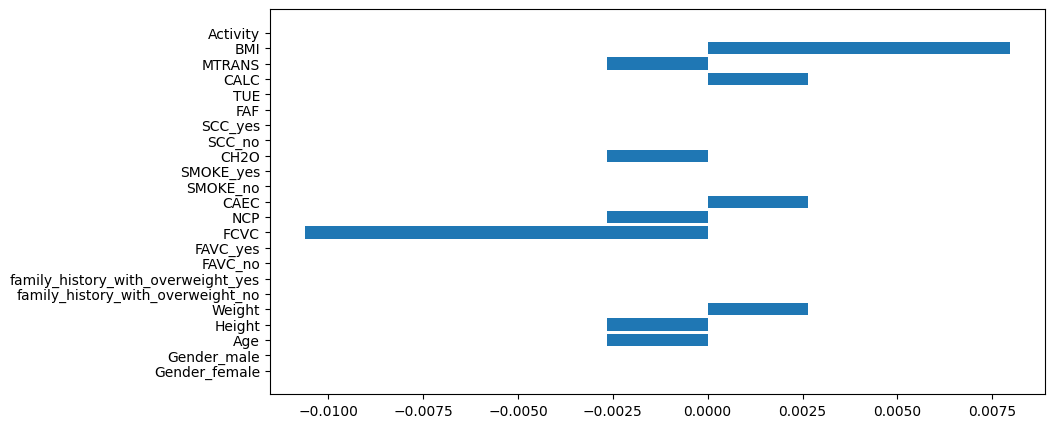

In [15]:
# 분리 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

# LR 모델 
model = SVC()
model.fit(x_train, y_train)
pred = model.predict(x_test)
recall_baseline = recall_score(y_test, pred, average = 'weighted')

importances =[]

for col in X.columns : 
    x_drop = X.drop(columns = [col])
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size = 0.3, random_state = 1234)
    model = SVC()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    recall_drop = recall_score(y_test, pred, average = 'weighted')

    diff = recall_baseline - recall_drop 
    importances.append({
        'Features' : col, 
        'Drop Recall' : diff
    })

imp_df = pd.DataFrame(importances)
print(imp_df.sort_values(by = 'Drop Recall' , ascending = False))
print('''
1. Recall > 0 : 변수를 제거했을 떄, Recall이 감소 >> 즉, 해당 변수가 있을때 모델의 성능이 좋다
2 .Recall < 0 : 변수를 제거했을 떄, Recall이 증가 >> 모델에 방해요인이 될 수 있다. 
''')

# 시각화 
plt.figure(figsize = (10, 5))
plt.barh(imp_df['Features'], imp_df['Drop Recall'])
plt.show()

#### Maching Learning-2

In [16]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv')
df.head(3)

,ID,키,weight,생년월일,건강검진일,공학여부,채소섭취정도,아침식사여부,일주일운동시간,수면시간,성별
0,ID_4135,169.01,65.47,20041003,2020_11_15,1,2,1,4.4,8.3,남성
1,ID_3289,181.62,69.36,19970725,2014_11_20,0,3,0,4.4,6.9,남성
2,ID_1847,160.89,65.12,20020921,2020_01_28,1,1,1,1.7,9.6,여성


In [17]:
# bmi 계산 
df['bmi'] = df['weight'] / (df['키'] / 100 ) ** 2

In [18]:
df['생년월일'] = pd.to_datetime(df['생년월일'], format = '%Y%m%d')
df['건강검진일'] = pd.to_datetime(df['건강검진일'], format = '%Y_%m_%d')

df['sub_year'] = df['건강검진일'].dt.year - df['생년월일'].dt.year
df['sub_days'] = (df['건강검진일'] - df['생년검진일']).dt.days 

def age_split(x) : 
    year = x['sub_year']
    days = x['sub_days']

    if year >= 17 : 
        return 17 
    elif year == 16 and days > 364 :
        return 17 
    else : 
        return 16 

df['age'] = df[['sub_year','sub_days']].apply(age_split, axis = 1)
df['age'].value_counts()

In [19]:
# 건강검진일 - 생년월일 = 년도만 
df['sub_year'] = df['건강검진일'].dt.year - df['생년월일'].dt.year 

# 날짜에서 년도 * 365일 뺴기 
df['day_diff'] = (df['건강검진일'] - df['생년월일']).dt.days - (df['sub_year'] * 365) 
df['age']= df.apply(lambda x : 17 if x['sub_year'] >= 17 or
                             x['sub_year'] == 16 and x['day_diff'] > 364 else 16,
                             axis = 1)
df['age'].value_counts()

age
17    5365
16    1436
Name: count, dtype: int64

In [20]:
# 만나이 
def bmi(x):
    BMI = x['bmi']
    age = x['age']
    gender = x['성별']
    
## 사이가 아닌것 확인하기 BMI범위 주의
    if gender =='남성':
        if age ==17:
            if BMI >= 21.03 and BMI < 23.21:
                return '적정'
            else:
                return '비적정'
    
        else:
            if BMI >= 21.18 and BMI < 23.45:
                return '적정'
            else:
                return '비적정'            
    
    else:
        if age ==17:
            if BMI >= 20.03 and BMI < 22.39:
                return '적정'
            else:
                return '비적정'
    
        else:
            if BMI >= 19.61 and BMI < 21.74:
                return '적정'
            else:
                return '비적정'       
                
df['적정체중여부'] = df.apply(bmi, axis = 1)
df['적정체중여부'].value_counts()

적정체중여부
적정     3911
비적정    2890
Name: count, dtype: int64

 3-1에서 구한 적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인

In [21]:
stat_df = df[['공학여부','아침식사여부','일주일운동시간','채소섭취정도','수면시간','성별','적정체중여부']]

res = []
for col in stat_df.columns.difference(['적정체중여부']) : 
    if stat_df[col].nunique() <= 5 : 
        cross = pd.crosstab(stat_df[col], stat_df['적정체중여부']) 
        stat, p_val, dof, _ = chi2_contingency(cross) 

        if p_val < 0.05 : 
            decision = '귀무가설기각-독립이아니다-유의하다'
        else : 
            decision = '귀무가설채택-독립이다'

    else : 
        g1 = stat_df[stat_df['적정체중여부'] == '적정'][col]
        g2 = stat_df[stat_df['적정체중여부'] == '비적정'][col]

        stat, p_val = ttest_ind(g1, g2)

        if p_val < 0.05 : 
            decision = '귀무가설기각-차이가 있다-유의하다'
        else : 
            decision = '귀무가설채택-차이가 없다'

    res.append([col, p_val , decision])

pd.DataFrame(res, columns = ['Columns','P_value', 'Decision'])

,Columns,P_value,Decision
0,공학여부,0.028622,귀무가설기각-독립이아니다-유의하다
1,성별,0.356966,귀무가설채택-독립이다
2,수면시간,0.008380,귀무가설기각-차이가 있다-유의하다
3,아침식사여부,0.545861,귀무가설채택-독립이다
4,일주일운동시간,0.526151,귀무가설채택-차이가 없다
5,채소섭취정도,0.024652,귀무가설기각-독립이아니다-유의하다


* 3.3 위에서 유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석을 하라 (로지스틱회귀 ,xgb)
- 로지스틱회귀 모델은 오즈비를 구하라 xgb의 경우 각 피쳐중요도를 확인하고 예측에 영향을 가장 미치는 변수를 확인

  Model  Accuracy  F1_score
0    LG  0.570799  0.726762
1   xgb  0.532092  0.629988
LG 공학여부      1.119872
수면시간      1.050529
채소섭취정도    0.978370
dtype: float64
xgb 공학여부      0.272632
수면시간      0.331757
채소섭취정도    0.395612
dtype: float32


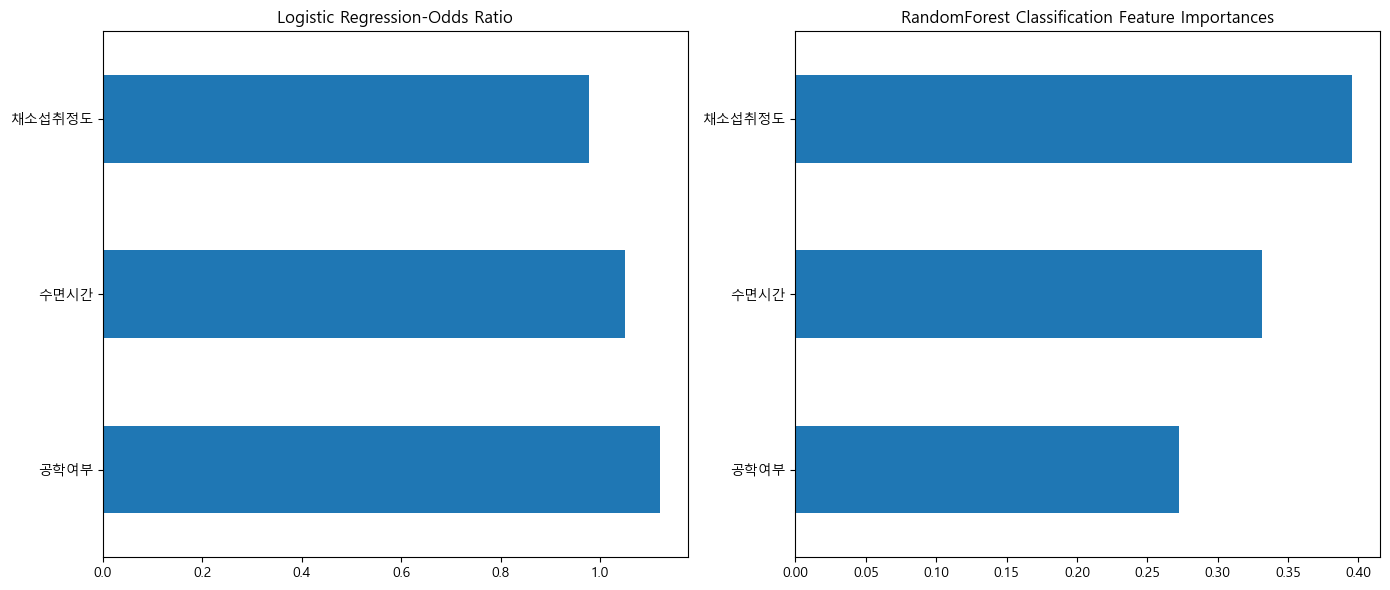

In [43]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

y = df['적정체중여부'].map({'적정':1 , '비적정' : 0})
X = df[['공학여부','수면시간','채소섭취정도']]

def classifying_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    return name, acc, f1 
res = []
model_lst = []
for name, model in [['LG', LogisticRegression()] , ['xgb' , XGBClassifier()]] : 
    name, acc, f1 = classifying_model(name, model) 
    model_lst.append([name, model])
    res.append({
        'Model' : name, 
        'Accuracy' : acc, 
        'F1_score' : f1
    })
print(pd.DataFrame(res)) 

fig, axes = plt.subplots(1,2, figsize = (14, 6))
for idx, (name, model) in enumerate(model_lst) : 
    if name == 'LG' : 
        odds = np.exp(model.coef_[0]) 
        features = model.feature_names_in_
        imp = pd.Series(odds, index = features)
        title = "Logistic Regression-Odds Ratio"
        
        
    elif name == 'xgb' : 
        importances = model.feature_importances_
        features = model.feature_names_in_
        imp = pd.Series(importances, index = features) 
        title = "RandomForest Classification Feature Importances"

    imp.plot(kind = 'barh', ax = axes[idx])
    axes[idx].set_title(title)
    plt.tight_layout()
    print(name,imp)

 3.4 두 모델의 roc-auc 그래프를 하나의 그래프에 겹쳐 그려라

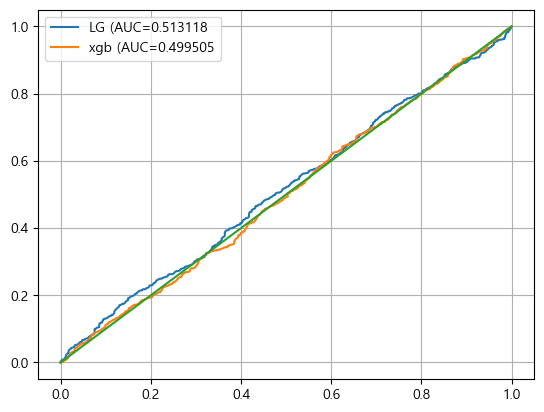

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score 

y = df['적정체중여부'].map({'적정':1 , '비적정' : 0})
X = df[['공학여부','수면시간','채소섭취정도']]

def classifying_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # predict_proba 
    pred_prob = model.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    auc = roc_auc_score(y_test, pred_prob)
    plt.plot(fpr, tpr, label = f'{name} (AUC={auc:2f}')
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred) 

    
    return name, acc, f1 

res = []
for name, model in [['LG', LogisticRegression()] , ['xgb' , XGBClassifier()]] : 
    name, acc, f1 = classifying_model(name, model) 
    model_lst.append([name, model])

plt.plot([0,1], [0,1])
plt.grid(True)
plt.legend()
plt.show()

어느 회사의 제품 무게는 N(?, 100) 의 정규분포를 따른다고 알려져 있다. 
이때, 사전적으로 우리는 제품의 평균 무게 가 정규분포 N(100, 256) 에서 온다고 가정한다. 
제품 중 하나의 실제 측정된 무게가 120kg일 때, 이 정보를 바탕으로 사후분포의 평균 

$$
\mu_{\text{posterior}} = \left( \frac{\mu_0}{\tau_0^2} + \frac{x}{\sigma^2} \right) \Bigg/ \left( \frac{1}{\tau_0^2} + \frac{1}{\sigma^2} \right)
$$
$$
= \left( \frac{100}{256} + \frac{120}{100} \right) \Bigg/ \left( \frac{1}{256} + \frac{1}{100} \right)
= \frac{1.590625}{0.01390625} \approx 114.38
$$
---


In [49]:
x = 100 
var = 256 

x_obs = 120
var_obs = 100 

# 베이지안 정규분포 추론
# 사후 평균 
(x / var + x_obs / var_obs) / (1/var + 1/var_obs)

114.3820224719101

어떤 실험 장비의 측정 오차는 정규분포 𝑁(𝜇,25)를 따른다고 알려져 있다.사전적으로 우리는 이 장비의 평균 오차 
μ가 정규분포 N(0,100)에서 왔다고 믿고 있다.
실제로 측정된 오차값이 8.0이었다면, 이 정보를 바탕으로 사후분포의 평균과 분산을 계산

In [51]:
x = 0 
var = 100 

obs_x = 8.0
obs_var = 25 

mean = (x/var + obs_x / obs_var) / (1/var + 1/obs_var)
print(mean)

var =  1 / (1/var + 1/obs_var)
print(var)

6.3999999999999995
20.0


In [52]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv',index_col = 0)
df.head(3)

,A,B,C,D,E
contract_1,1,0,1,1,1
contract_2,0,1,0,1,0
contract_3,1,0,0,0,0


In [53]:
from statsmodels.stats.contingency_tables import cochrans_q

coc = cochrans_q(df)
print(coc.pvalue)

0.3406392758219471
